### PLACE ALL IMPORTS HERE (easier to keep track of)

In [99]:
# general
from __future__ import division
from collections import defaultdict
from collections import Counter
import os
import random

# to read in JSON character objects 
import json

# for stopwords
import nltk

# for LDA topic modeling
from gensim import corpora, models, similarities 

# for lots of math junk and plotting
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# for making data frames
import pandas as pd

# for clustering, etc.
from sklearn import metrics
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import euclidean_distances
from scipy.cluster.hierarchy import ward, dendrogram


# Read in character JSON, build feature vectors for a BOW-type model

In [100]:

# source_dir = "C:\\Users\\Molly\\Google Drive\\senior classes\\nlp\\term_project\\book-nlp-master\\book-nlp-master\\data\\originalTexts"
# # for filename in os.listdir(source_dir):
# #     print filename
# #     bookfile = open(source_dir + "\\" + filename, 'r')
# #     book = bookfile.read()
# #     bookDict = defaultdict(float)
# #     for word in book.split():
# #         bookDict[word] += 1
# #     counter = Counter(bookDict)
# #     top_n = counter.most_common(100)
# #     print top_n
# bookfile = open(source_dir + '\\full_hp.txt', 'r')
# book = bookfile.read()
# bookDict = defaultdict(float)
# for word in book.split():
#     bookDict[word] += 1
# counter = Counter(bookDict)
# top_n = counter.most_common(200)
# print top_n
# print

#### Paste in direct path to the JSON file (because the relative paths aren't working)

In [101]:
wk_dir = os.path.dirname(os.path.realpath('__file__'))

#json_filename = os.path.join(wk_dir, "..", "booknlp_output\\potter.all.book.txt")
json_filename = "C:\\Users\\Molly\\Google Drive\\senior classes\\nlp\\term_project\\char-net\\booknlp_output\\book.id.book";

with open(json_filename) as json_file:
	char_json = json.load(json_file)
print "successfully loaded json"

successfully loaded json


#### Load stopwords list, combine it with NLTK's English stopwords list (add words to list as needed)

In [102]:
stopwords = nltk.corpus.stopwords.words('english')
curDir = os.path.dirname(os.path.realpath('__file__'))
stop = os.path.join(curDir,'stopwords')     
stopfile = open(stop, 'r')
stop = stopfile.read()
for word in stop.split():
    stopwords.append(word)
print stopwords
stopwords = set(stopwords)

[u'i', u'me', u'my', u'myself', u'we', u'our', u'ours', u'ourselves', u'you', u'your', u'yours', u'yourself', u'yourselves', u'he', u'him', u'his', u'himself', u'she', u'her', u'hers', u'herself', u'it', u'its', u'itself', u'they', u'them', u'their', u'theirs', u'themselves', u'what', u'which', u'who', u'whom', u'this', u'that', u'these', u'those', u'am', u'is', u'are', u'was', u'were', u'be', u'been', u'being', u'have', u'has', u'had', u'having', u'do', u'does', u'did', u'doing', u'a', u'an', u'the', u'and', u'but', u'if', u'or', u'because', u'as', u'until', u'while', u'of', u'at', u'by', u'for', u'with', u'about', u'against', u'between', u'into', u'through', u'during', u'before', u'after', u'above', u'below', u'to', u'from', u'up', u'down', u'in', u'out', u'on', u'off', u'over', u'under', u'again', u'further', u'then', u'once', u'here', u'there', u'when', u'where', u'why', u'how', u'all', u'any', u'both', u'each', u'few', u'more', u'most', u'other', u'some', u'such', u'no', u'nor', u

#### Create character feature vectors (TODO: ADD IN DIALOGUE FEATURES HERE)

In [103]:
# dictionary of lists of character attributes, indexed by name (i.e. character's "bag of words")
characters = {}

for character in char_json["characters"]:
    # TODO: throw out characters that are mentioned less than 10 times (play with this threshold?)
    if character["NNPcount"] > 20:
        char_name = character["names"][0]['n']
        characters[char_name] = []
        for word_dict in character["patient"]:
            curWord = word_dict['w']
            if curWord.lower() not in stopwords:
                characters[char_name].append(curWord + "_PATIENT")
        for word_dict in character["agent"]:
            curWord = word_dict['w']
            if curWord.lower() not in stopwords:
                characters[char_name].append(curWord + "_AGENT")
        for word_dict in character["mod"]:
            curWord = word_dict['w']
            if curWord.lower() not in stopwords:
                characters[char_name].append(curWord + "_MOD")
                
        #TODO: add dialogue features?
#         for word_dict in character['speaking']:
#             print char_name
#             print word_dict['w']
                
        # are things characters possess indicative of their character? Often not, so maybe exclude
        for word_dict in character["poss"]:
            curWord = word_dict['w']
            if curWord.lower() not in stopwords:
                characters[char_name].append(word_dict['w'] + "_POSS")

texts = [None for i in range(len(characters))]
names = defaultdict(float)
i = 0
for key, value in characters.iteritems():
	print str(key) + ": " + str(value)
	texts[i] = value
	names[key] = i
	i += 1
	print

Madam Rosmerta: [u'forced_PATIENT', u'gasped_PATIENT', u'breathed_PATIENT', u'staring_AGENT', u'filling_AGENT', u'eject_wizard_AGENT', u'tottering_AGENT', u'send_bottle_AGENT', u'have_other_AGENT', u'saw_AGENT', u'tip_you_AGENT', u'help_[Malfoy/Draco Malfoy/Draco]_AGENT', u'admitted_AGENT', u'let_sigh_AGENT', u'able_MOD', u'mead_POSS', u'pub_POSS', u'bathroom_POSS', u'messages_POSS', u'talking_POSS', u'voice_POSS', u'voice_POSS', u'voice_POSS']

Fang: [u'take_PATIENT', u'swept_PATIENT', u'bless_PATIENT', u'take_PATIENT', u'fended_PATIENT', u'leave_PATIENT', u'carrying_PATIENT', u'pushed_PATIENT', u'bowled_PATIENT', u'stroking_PATIENT', u'found_PATIENT', u'want_PATIENT', u'transfixed_PATIENT', u'started_AGENT', u'bounded_AGENT', u'let_AGENT', u'yelped_AGENT', u'kept_AGENT', u'whimpering_AGENT', u'fighting_AGENT', u'thudded_AGENT', u'howling_AGENT', u'howling_AGENT', u'fling_himself_AGENT', u'trembling_AGENT', u'ter_AGENT', u'shove_I_AGENT', u'lolloping_AGENT', u'galloping_AGENT', u'save

## Do LDA Topic Modeling Using Character Features

In [104]:
# create Gensim dictionary from the texts
dictionary = corpora.Dictionary(texts)

# create bag of words model to perform analysis
corpus = [dictionary.doc2bow(text) for text in texts]

numtopics = 15

lda = models.LdaModel(corpus, num_topics=numtopics, 
                            id2word=dictionary, 
                            update_every=5, 
                            chunksize=100, 
                            passes=100)


In [105]:
print(lda.show_topics())

[u'0.013*wand_POSS + 0.009*voice_POSS + 0.006*do_what_AGENT + 0.006*turned_AGENT + 0.004*mother_POSS + 0.004*father_POSS + 0.004*looking_AGENT + 0.004*say_what_AGENT + 0.003*shoulder_POSS + 0.003*going_AGENT', u'0.015*wand_POSS + 0.010*thought_AGENT + 0.009*felt_AGENT + 0.007*voice_POSS + 0.006*saw_AGENT + 0.006*turned_AGENT + 0.005*sat_AGENT + 0.005*stared_AGENT + 0.004*stood_AGENT + 0.004*wanted_AGENT', u'0.009*voice_POSS + 0.005*portrait_POSS + 0.004*son_POSS + 0.004*sister_POSS + 0.003*died_AGENT + 0.003*frame_POSS + 0.003*letter_POSS + 0.002*watched_PATIENT + 0.002*laughed_AGENT + 0.002*killed_PATIENT', u'0.013*wand_POSS + 0.010*voice_POSS + 0.005*diary_POSS + 0.004*added_AGENT + 0.004*going_AGENT + 0.004*turned_AGENT + 0.003*called_AGENT + 0.003*hair_POSS + 0.003*husband_POSS + 0.003*followed_PATIENT', u"0.032*Hollow_POSS + 0.006*sister_POSS + 0.003*wand_POSS + 0.002*wife_POSS + 0.002*passed_AGENT + 0.002*disappeared_AGENT + 0.002*pointed_AGENT + 0.002*hair_POSS + 0.002*walked_AG

#### Print top n words for each topic (TODO: make some kind of visualization for this)

In [106]:
for i in range(0, numtopics):
    print i
    print lda.show_topic(i, 10)
    print

0
[(0.028303039333819436, u'cage_POSS'), (0.005119662385546603, u'beak_POSS'), (0.004395181745526131, u'hooted_AGENT'), (0.0029462209622804995, u'gone_AGENT'), (0.0029462208701932198, u'wand_POSS'), (0.0029462208651390349, u'sent_PATIENT'), (0.0022217403630709733, u'landed_AGENT'), (0.0022217403616345073, u'returned_AGENT'), (0.0022217403532398118, u'watched_PATIENT'), (0.0022217403354141785, u'speak_AGENT')]

1
[(0.015881650237397724, u'wand_POSS'), (0.010946369012049699, u'voice_POSS'), (0.0093785934333010575, u'office_POSS'), (0.0053828345491755509, u'mind_POSS'), (0.0052388143165068117, u'clipboard_POSS'), (0.005174511233596208, u'going_AGENT'), (0.0044632363022680628, u'name_POSS'), (0.0043751449709172417, u'returned_AGENT'), (0.0041725628217085383, u'fingers_POSS'), (0.0041159381289929547, u'turned_AGENT')]

2
[(0.013410375398476185, u'wand_POSS'), (0.0099760311438734355, u'voice_POSS'), (0.0051593922492359006, u'diary_POSS'), (0.0041724067547555758, u'added_AGENT'), (0.004054000

#### Create topic matrix (dimensions num_characters x num_topics) containing topic probabilities for each character

In [107]:
topic_matrix = [[0 for i in range(numtopics)] for namekey in names]
print len(topic_matrix)
i = 0
for namekey in names:
    print str(namekey) + " topic distribution: "
    for (key, value) in lda[corpus[names[namekey]]]:
        topic_matrix[i][key] = value
    i+=1
    print lda[corpus[names[namekey]]]

154
Madam Rosmerta topic distribution: 
[(9, 0.96111107439862709)]
Fang topic distribution: 
[(3, 0.99135801605629703)]
Hogsmeade topic distribution: 
[(4, 0.92222217133451967)]
Lupin topic distribution: 
[(3, 0.99811065930497544)]
Dudley topic distribution: 
[(13, 0.99810682695237318)]
Cho topic distribution: 
[(11, 0.47755507772653666), (13, 0.5166671399104249)]
Roger Davies topic distribution: 
[(2, 0.97254899932314409)]
Dolohov topic distribution: 
[(7, 0.35960367946809857), (13, 0.61413366108399636)]
Madam Hooch topic distribution: 
[(12, 0.97829454834067919)]
Ravenclaw topic distribution: 
[(2, 0.9450980131635528)]
Dad topic distribution: 
[(3, 0.96888887367872667)]
Lavender Brown topic distribution: 
[(2, 0.94814809170200298)]
Bertha Jorkins topic distribution: 
[(11, 0.98721460003295392)]
Malfoys topic distribution: 
[(5, 0.90666654885545328)]
Amos Diggory topic distribution: 
[(9, 0.92820501532016475)]
Montague topic distribution: 
[(11, 0.95087714982244842)]
Marietta topic di

#### Bar plot visualization of above character topic probabilities

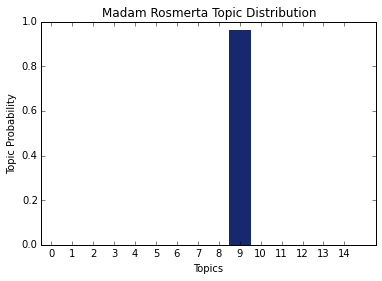

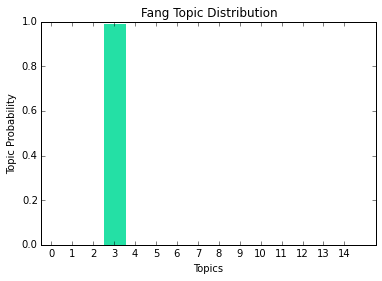

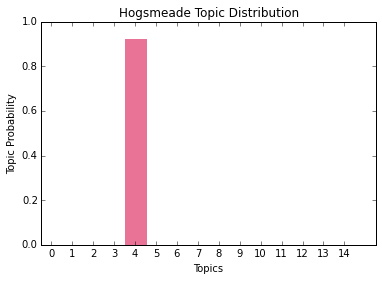

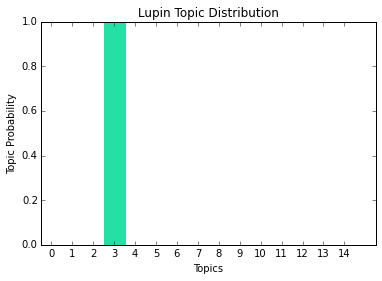

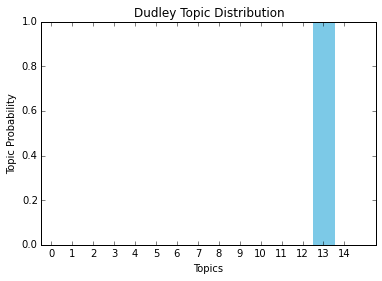

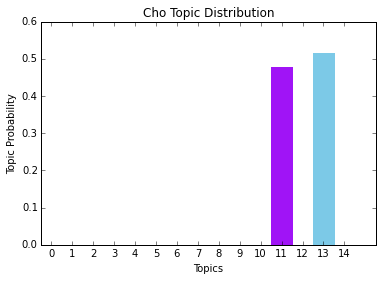

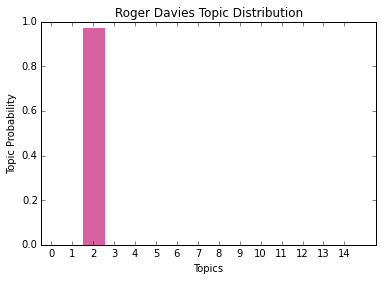

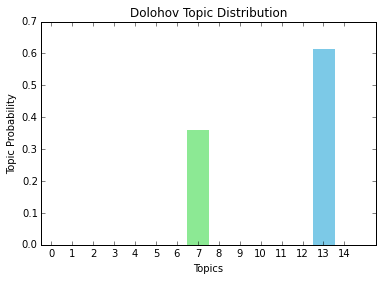

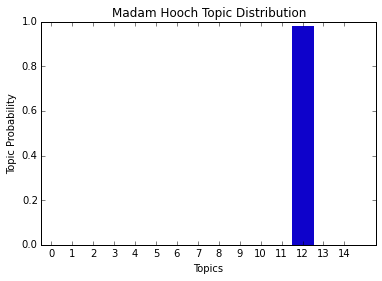

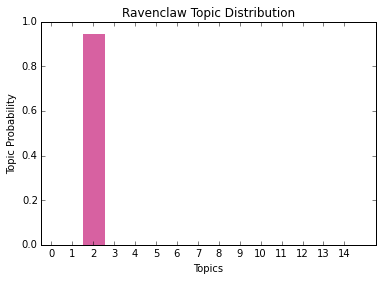

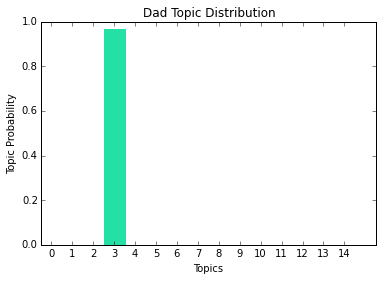

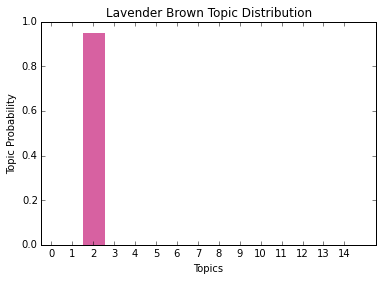

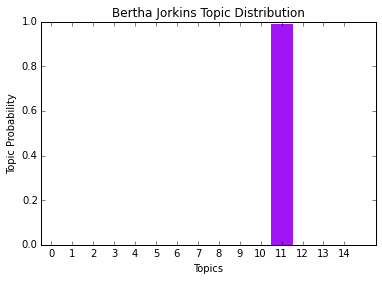

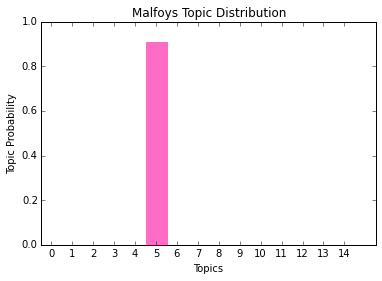

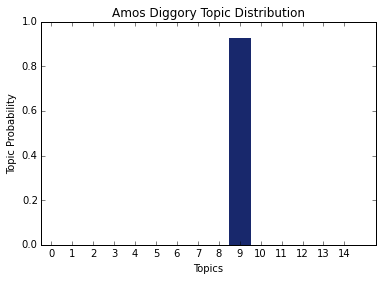

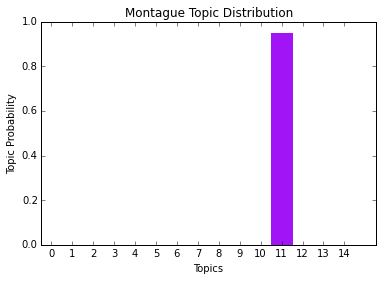

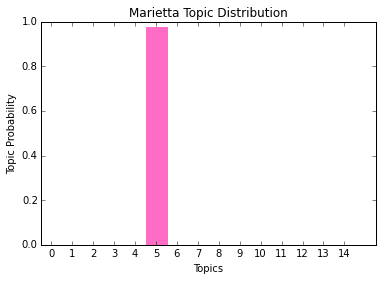

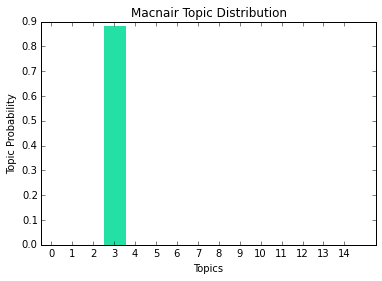

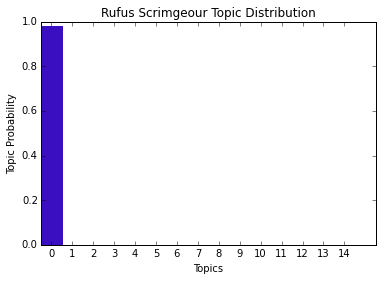

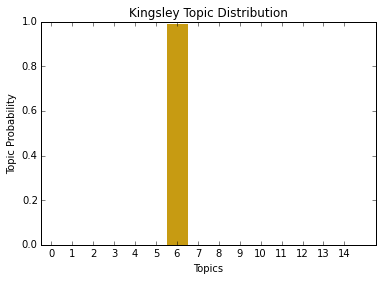

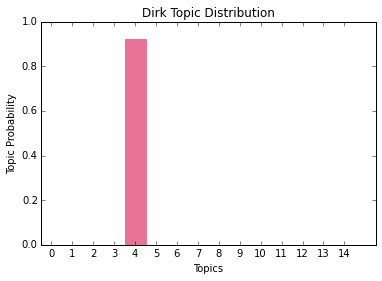

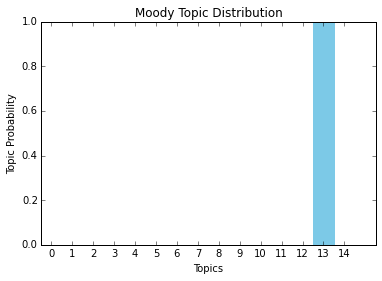

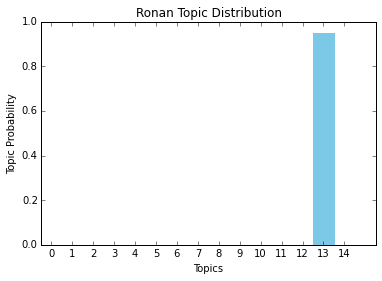

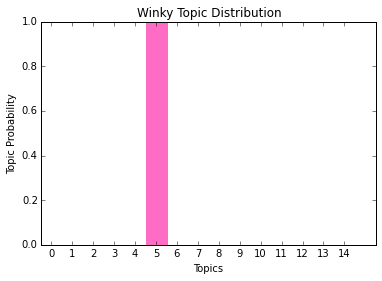

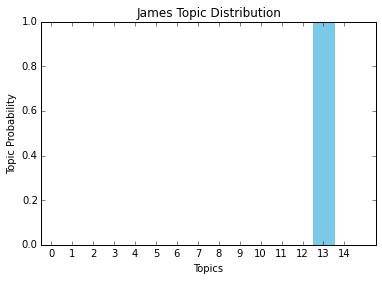

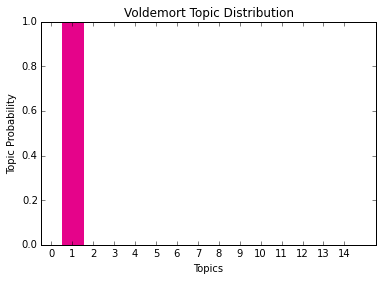

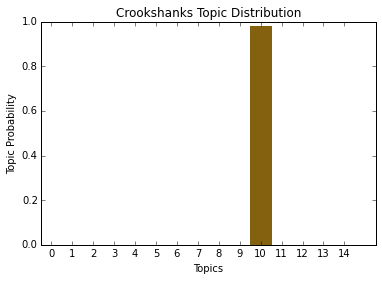

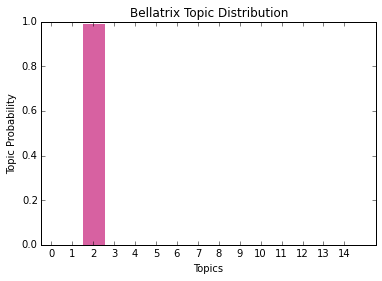

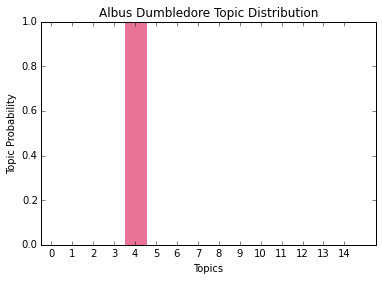

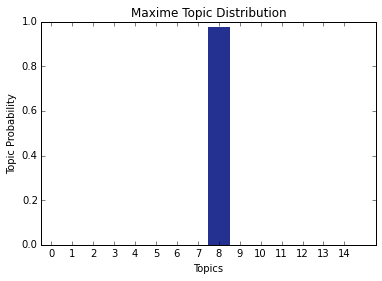

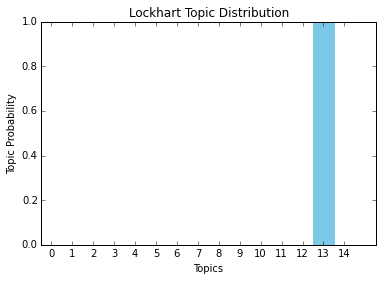

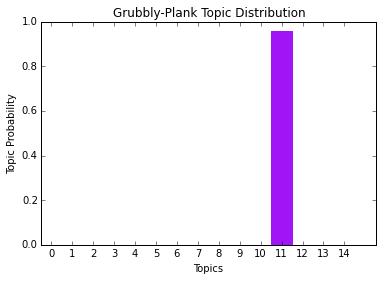

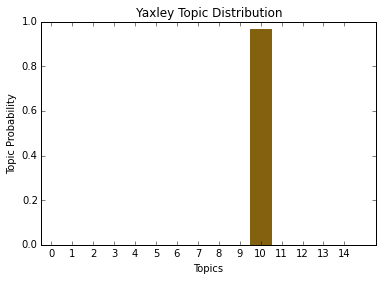

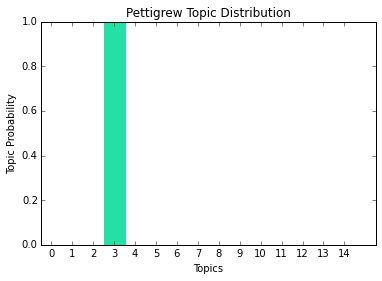

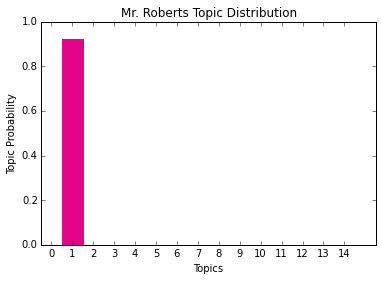

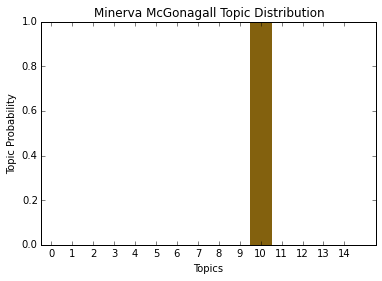

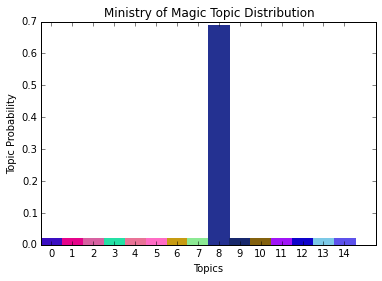

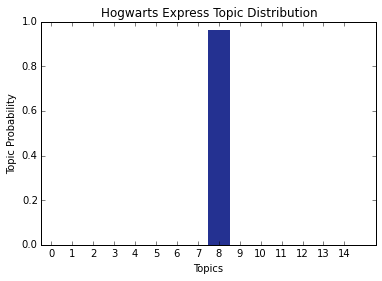

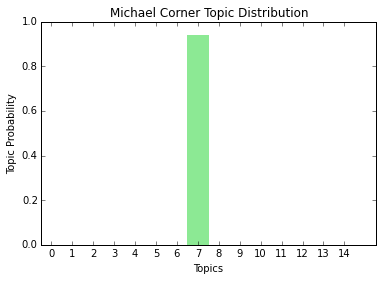

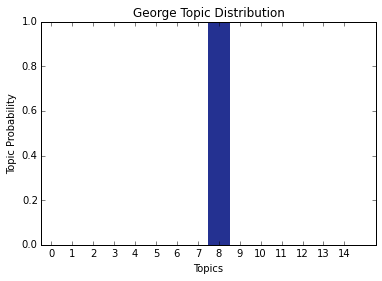

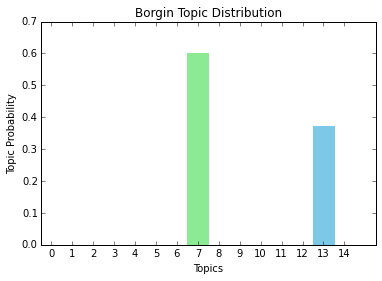

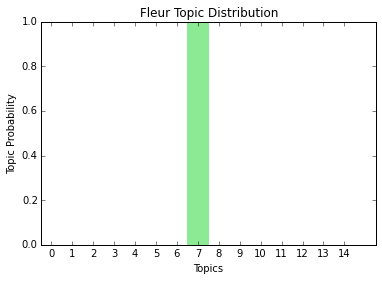

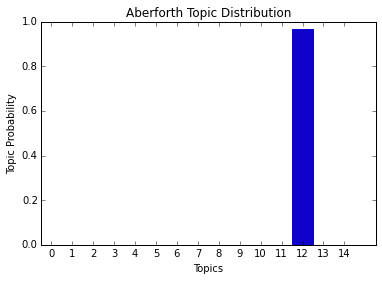

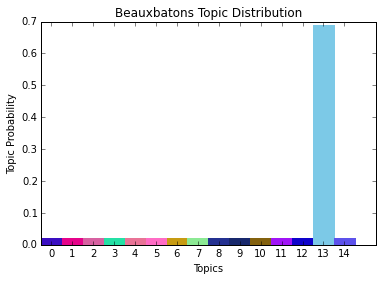

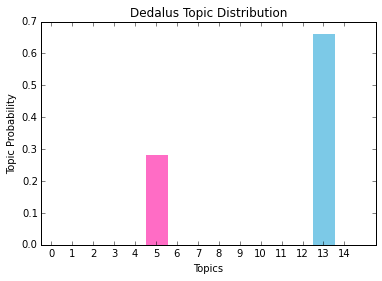

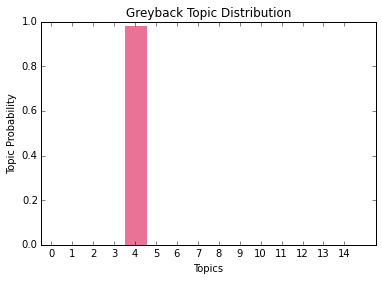

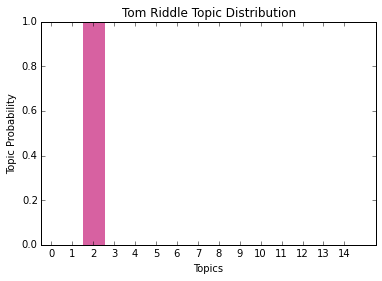

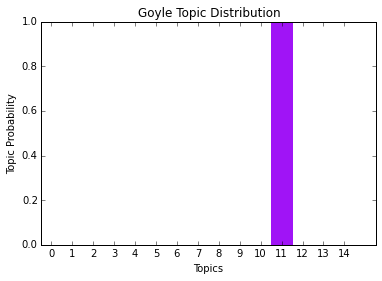

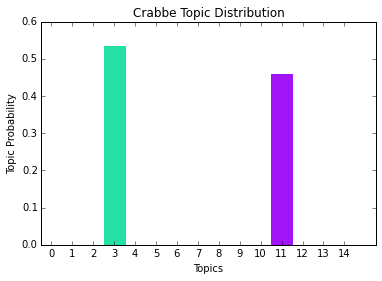

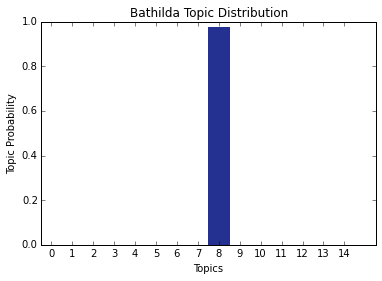

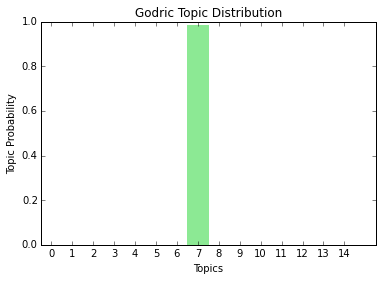

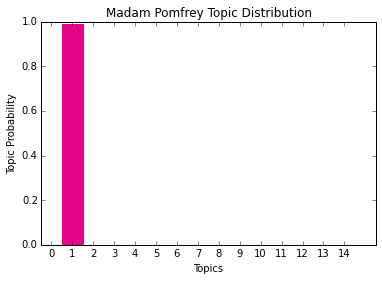

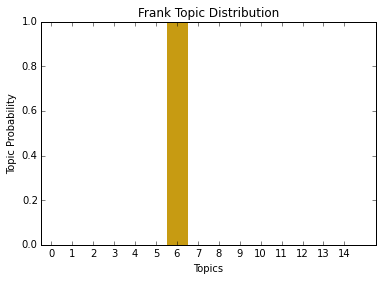

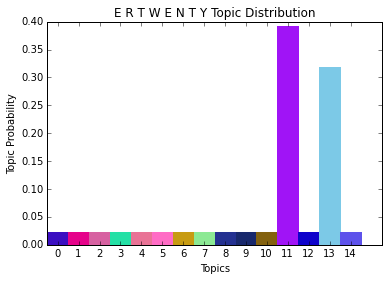

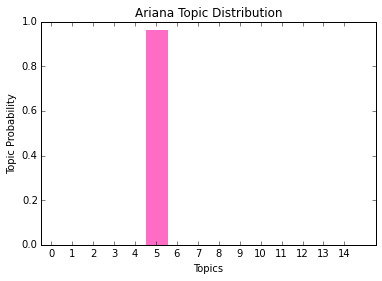

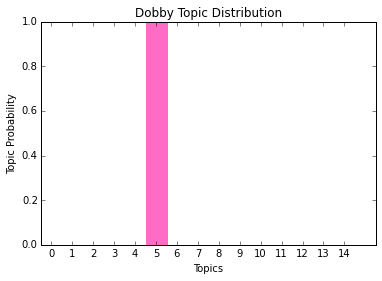

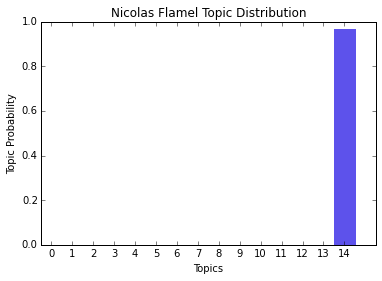

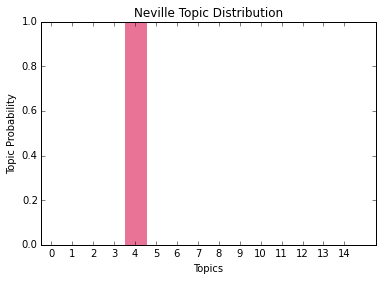

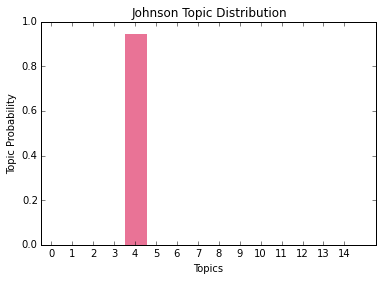

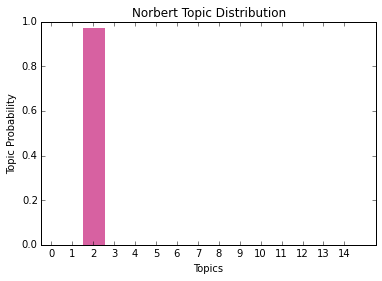

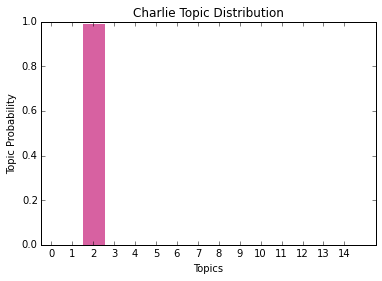

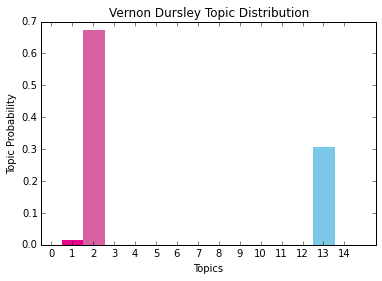

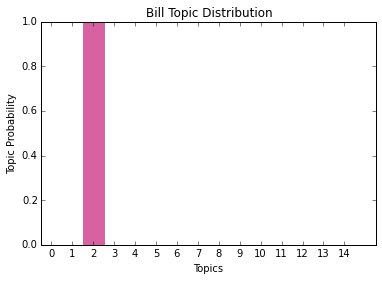

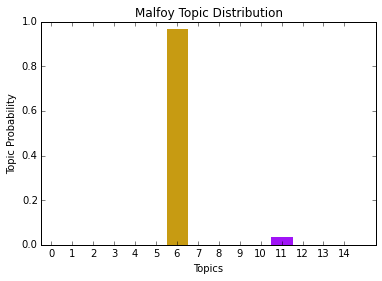

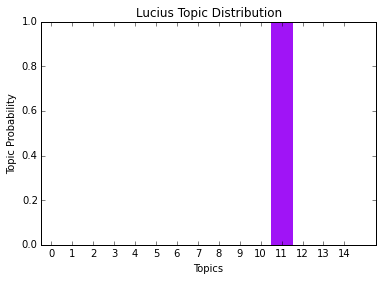

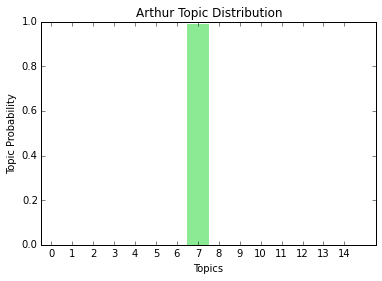

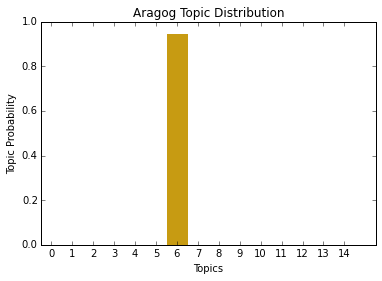

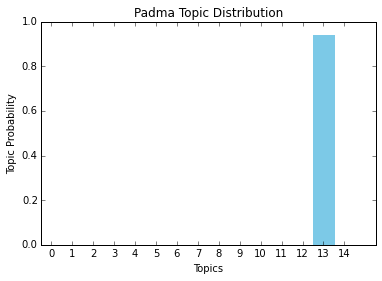

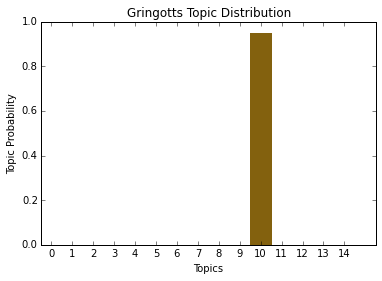

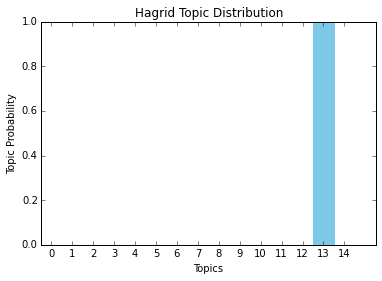

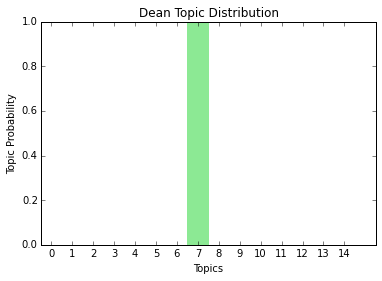

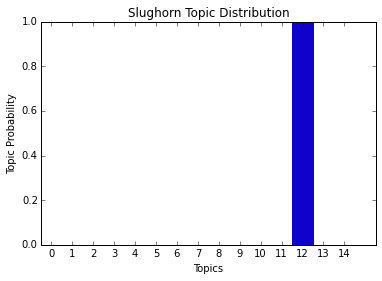

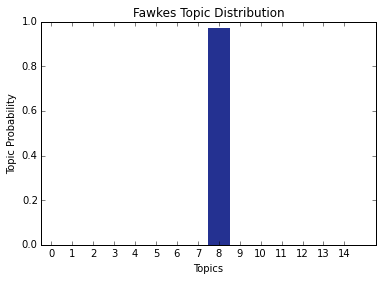

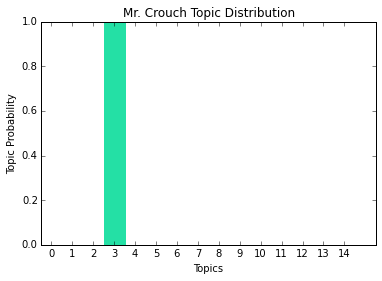

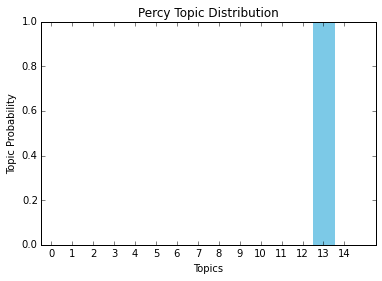

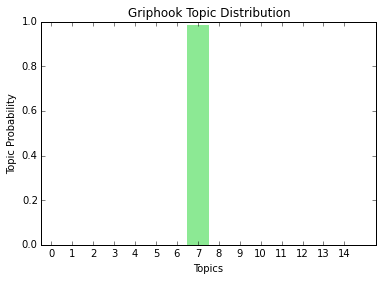

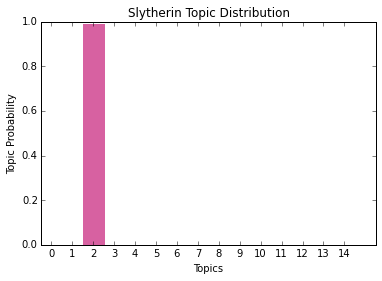

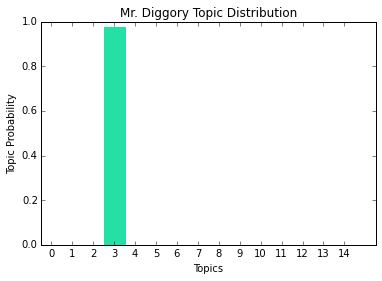

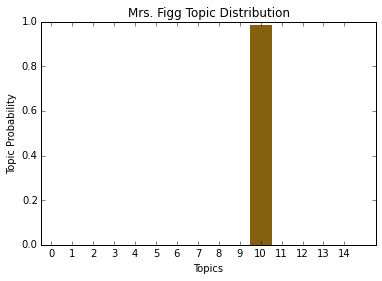

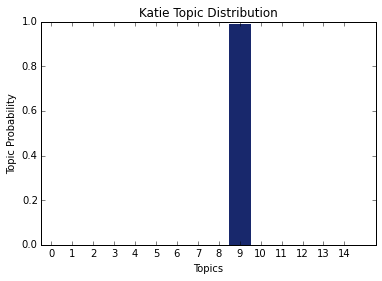

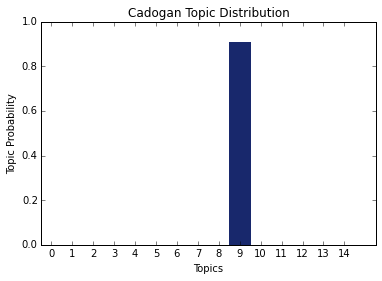

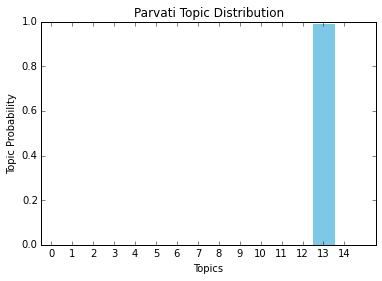

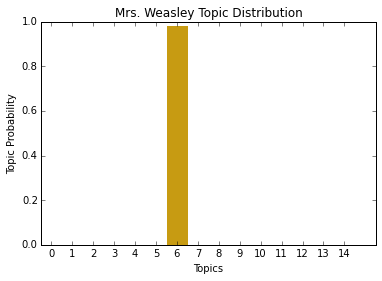

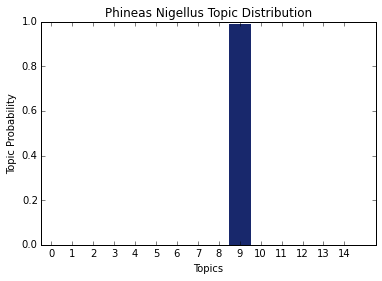

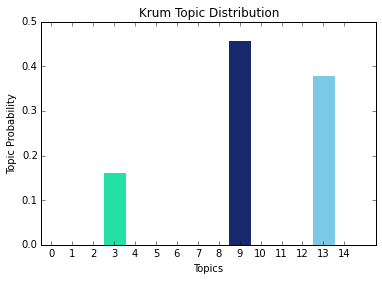

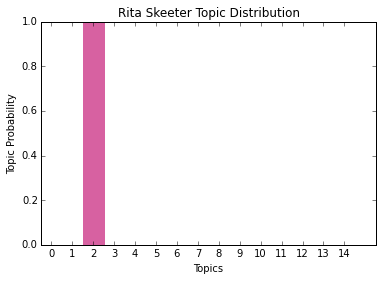

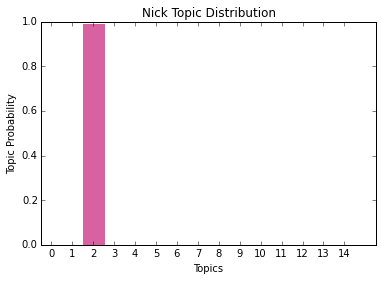

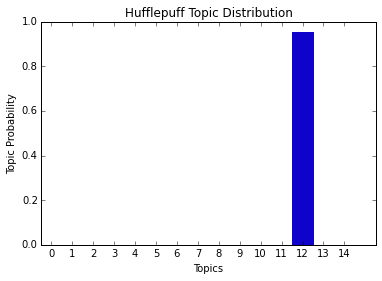

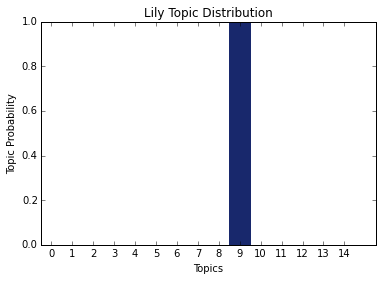

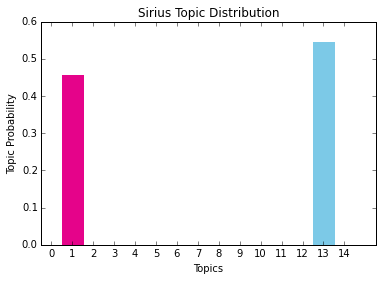

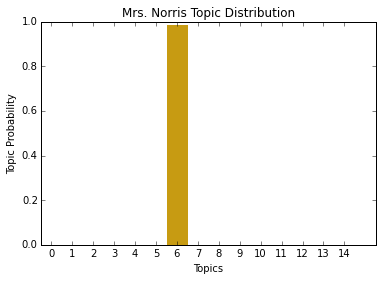

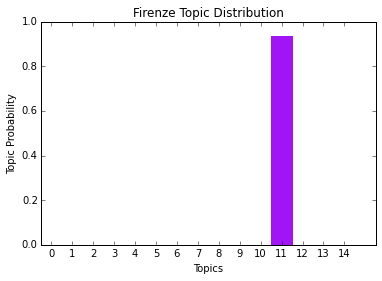

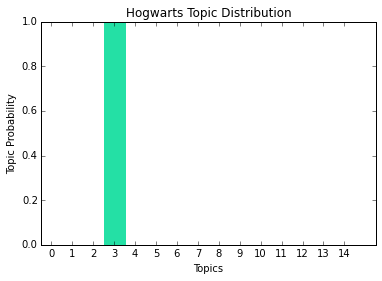

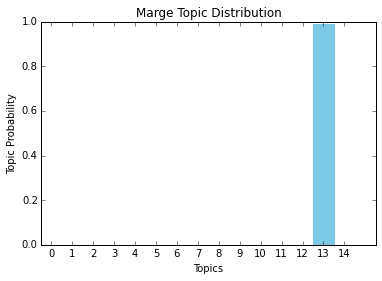

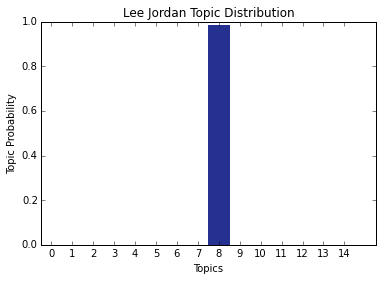

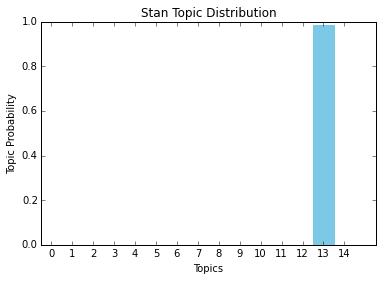

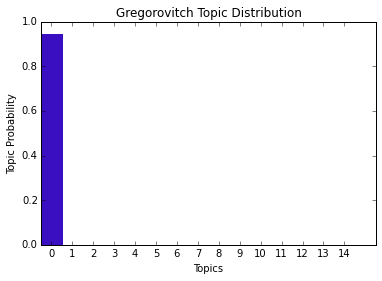

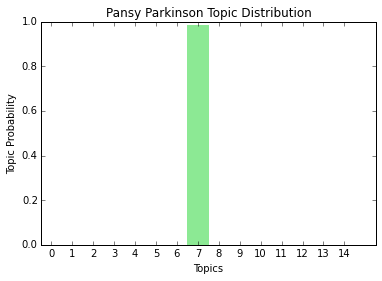

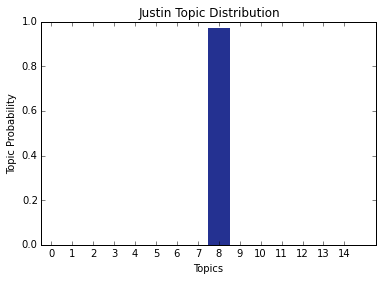

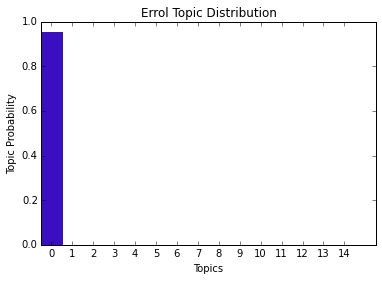

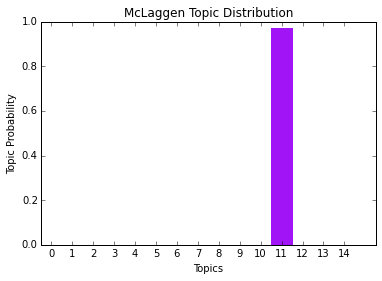

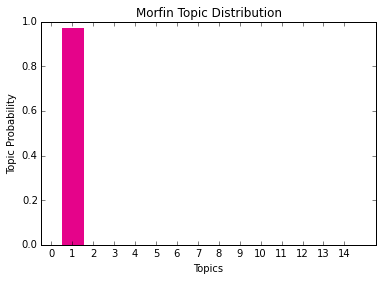

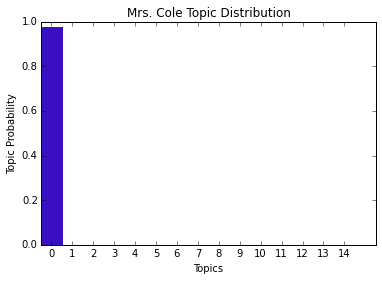

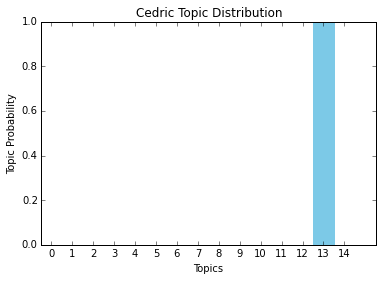

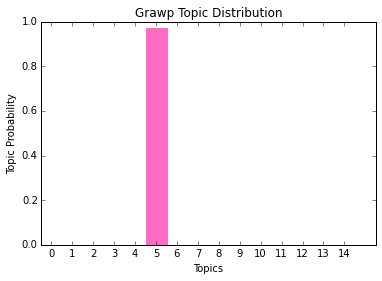

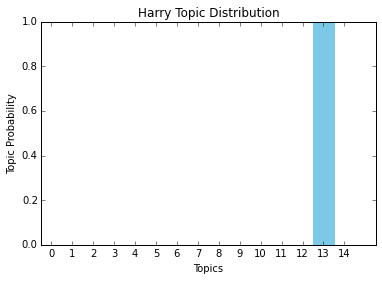

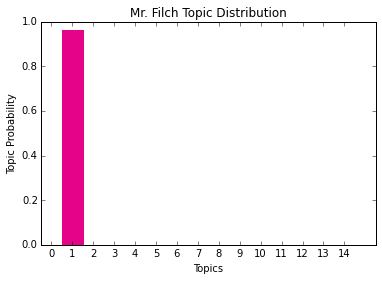

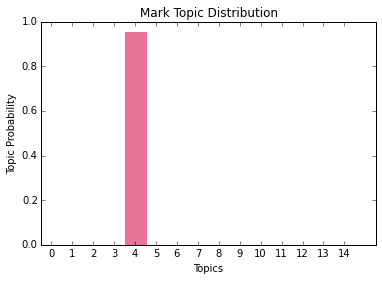

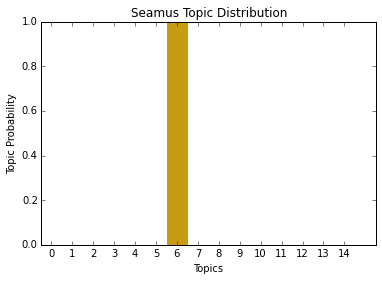

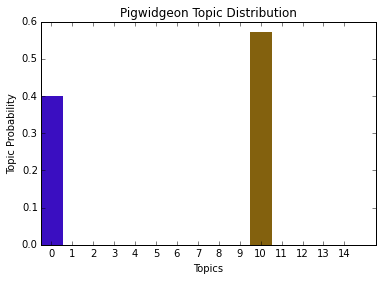

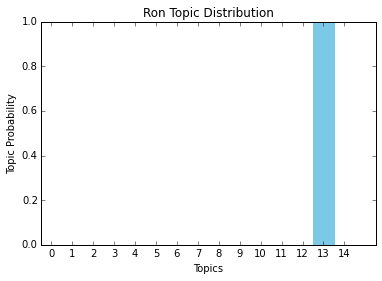

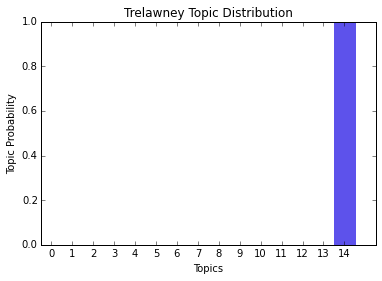

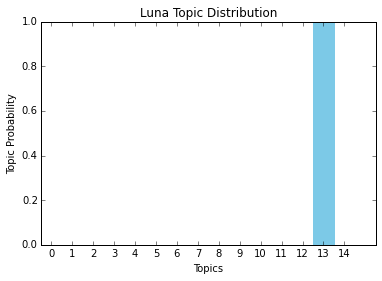

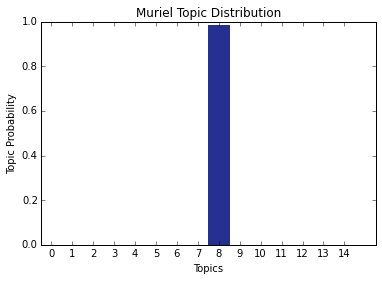

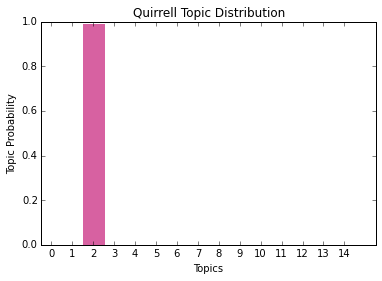

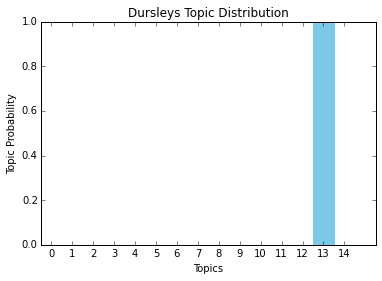

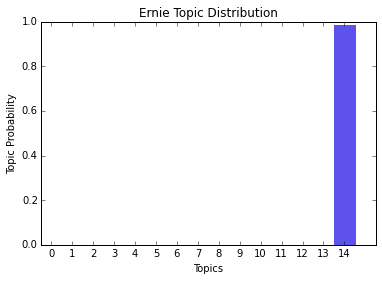

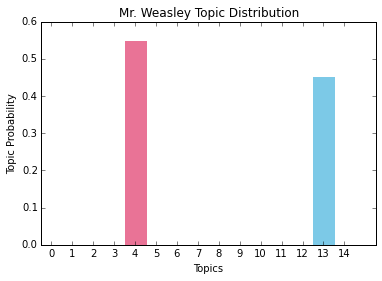

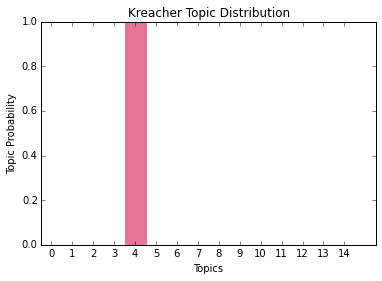

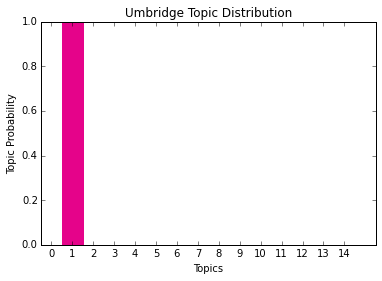

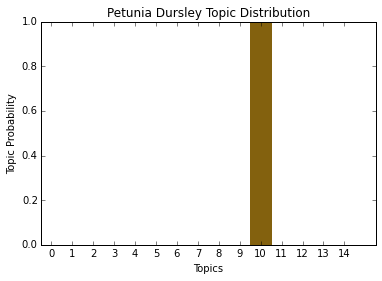

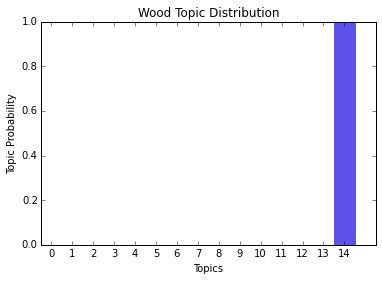

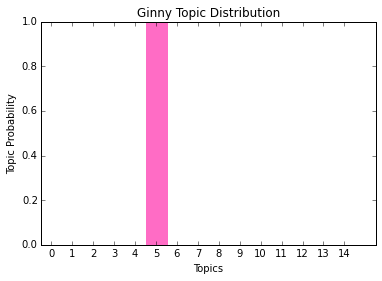

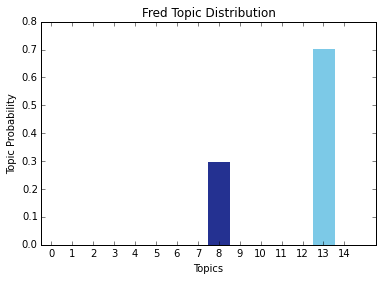

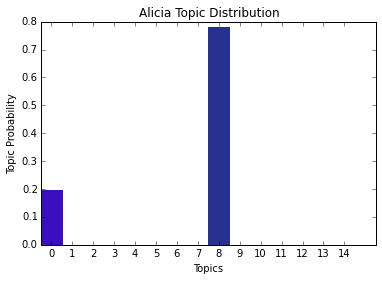

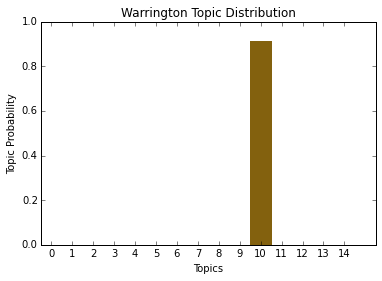

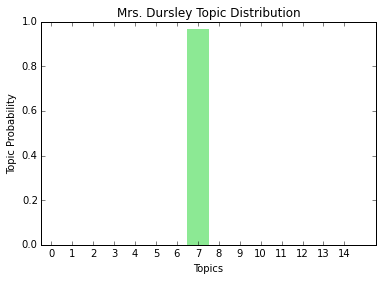

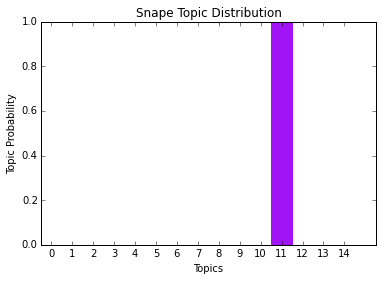

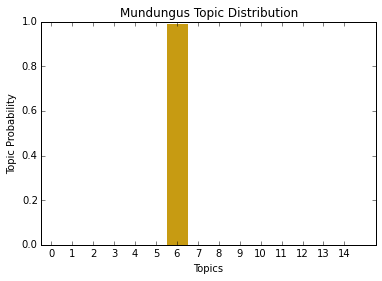

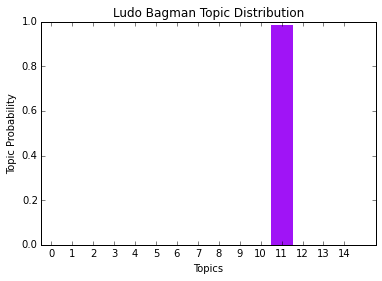

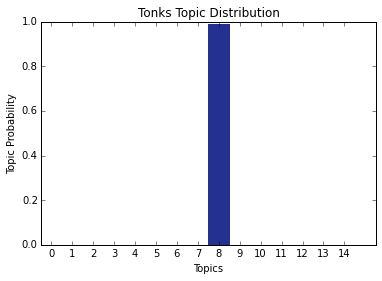

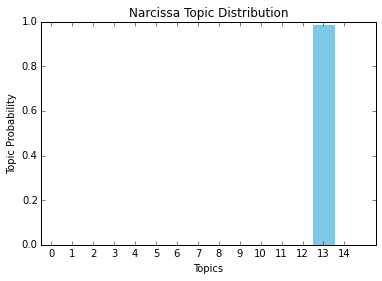

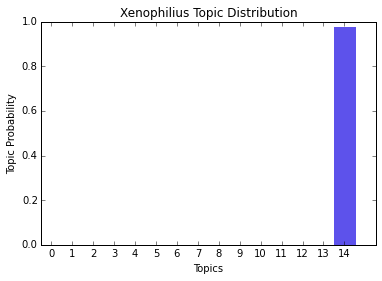

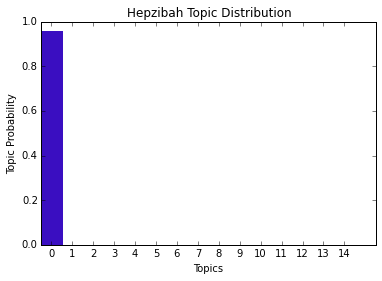

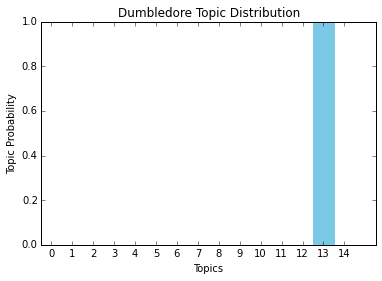

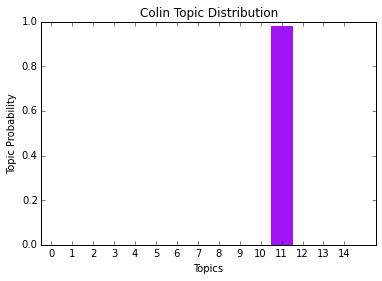

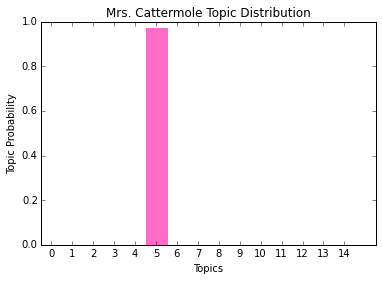

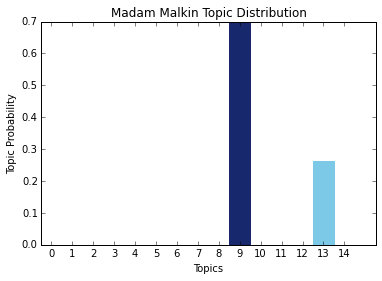

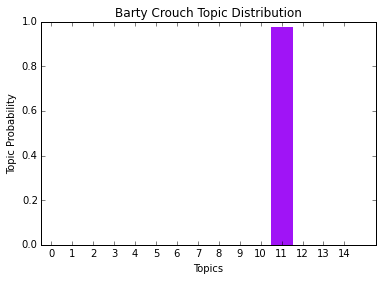

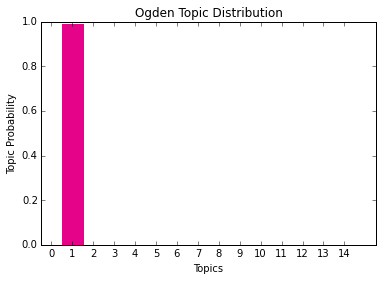

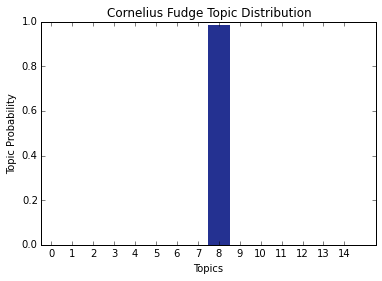

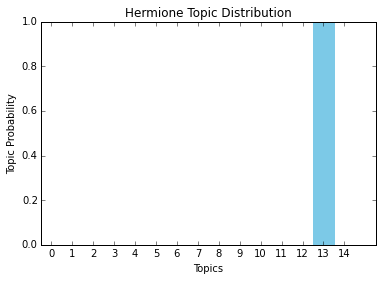

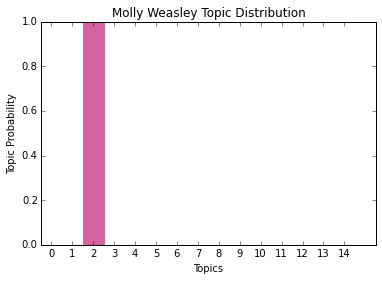

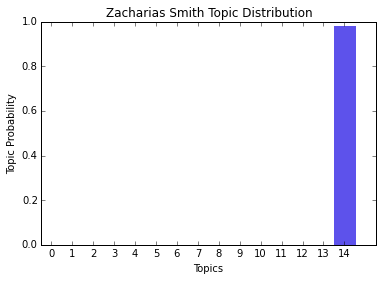

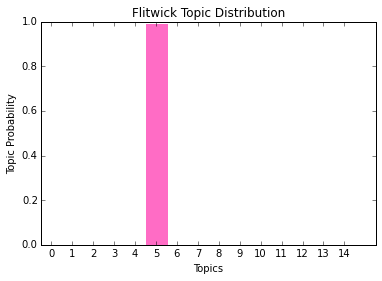

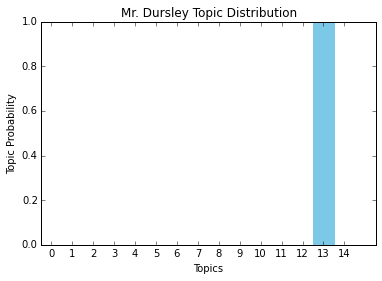

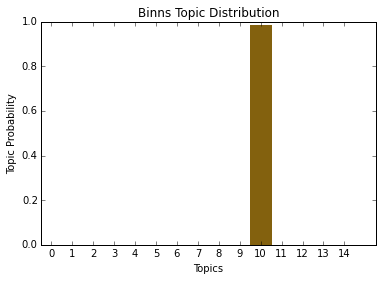

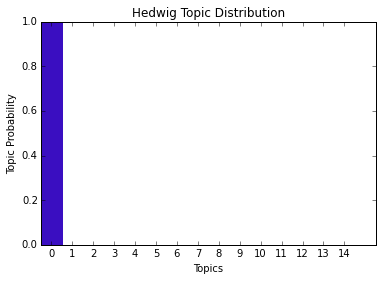

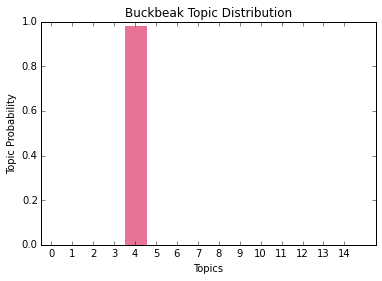

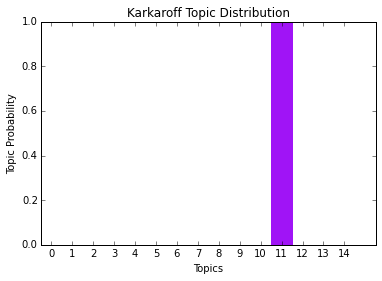

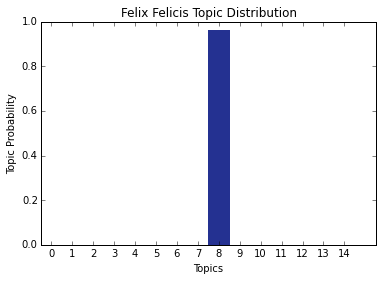

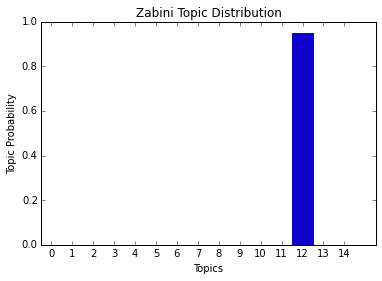

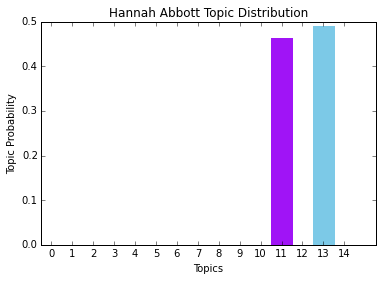

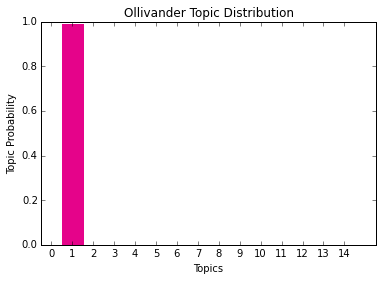

In [108]:
# TODO try to plot bar charts for each character
topicColors = []
for i in range(numtopics):
    r = lambda: random.randint(0,255)
    color = '#%02X%02X%02X' % (r(),r(),r())
    topicColors.append(color)

plots = []
%matplotlib inline 

nameit = names.iterkeys()
for charArray in topic_matrix:
    ind = np.arange(len(charArray))  # the x locations for the groups
    fig, ax = plt.subplots()
    width = 1
    
    topicNames = []
    topicProbs = []
    for i in range(len(charArray)):
        topicNames.append(i)
    
    rects1 = ax.bar(ind, charArray, width)
    for i in range(len(charArray)):
        rects1[i].set_color(topicColors[topicNames[i]])
        
    # add some text for labels, title and axes ticks
    ax.set_ylabel('Topic Probability')
    ax.set_xlabel('Topics')
    title =  nameit.next() + ' Topic Distribution'
    ax.set_title(title)
    ax.set_xticks(ind + width/2)
    ax.set_xticklabels(topicNames)
    plt.show()


## Perform Clustering Based on Character Topic Vectors

#### Use KMeans (is this the best choice?) and print out the clusters list

In [109]:
data = np.array(topic_matrix)

from sklearn.cluster import KMeans
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(data)
clusters = kmeans.labels_.tolist()
print clusters
# "The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters."
goodness = metrics.silhouette_score(data, kmeans.labels_, metric='euclidean')
print "silhouette score: " + str(goodness)
# within-cluster sum of squares
print "inertia: " + str(kmeans.inertia_)

[1, 1, 1, 1, 2, 2, 3, 2, 1, 3, 1, 3, 0, 1, 1, 0, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 3, 1, 1, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 3, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 1, 0, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 3, 1, 1, 1, 1, 2, 1, 1, 1, 3, 3, 1, 1, 2, 1, 0, 1, 2, 1, 2, 1, 1, 1, 1, 0, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 3, 2, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 0, 1, 0, 1, 2, 1, 1, 2, 0, 1, 1, 0, 1, 1, 2, 3, 1, 1, 2, 1, 1, 1, 0, 1, 1, 2, 1]
silhouette score: 0.319005826817
inertia: 85.6180563152


#### Print out characters and cluster assignments (in order)

In [110]:
dic={}
i=0
for nameKey in names:
    dic[str(nameKey)]=clusters[i]
    i += 1
d=sorted(dic.items(), key=lambda x:x[1])
for name in d:
    print name

('Bertha Jorkins', 0)
('Montague', 0)
('Grubbly-Plank', 0)
('Goyle', 0)
('Crabbe', 0)
('Lucius', 0)
('Karkaroff', 0)
('Firenze', 0)
('McLaggen', 0)
('Snape', 0)
('Ludo Bagman', 0)
('Colin', 0)
('Barty Crouch', 0)
('Madam Rosmerta', 1)
('Fang', 1)
('Hogsmeade', 1)
('Lupin', 1)
('Madam Hooch', 1)
('Dad', 1)
('Malfoys', 1)
('Pigwidgeon', 1)
('Marietta', 1)
('Macnair', 1)
('Rufus Scrimgeour', 1)
('Kingsley', 1)
('Dirk', 1)
('Winky', 1)
('Voldemort', 1)
('Crookshanks', 1)
('Zabini', 1)
('Albus Dumbledore', 1)
('Maxime', 1)
('Yaxley', 1)
('Pettigrew', 1)
('Mr. Roberts', 1)
('Minerva McGonagall', 1)
('Ministry of Magic', 1)
('Hogwarts Express', 1)
('Michael Corner', 1)
('George', 1)
('Mr. Diggory', 1)
('Fleur', 1)
('Aberforth', 1)
('Greyback', 1)
('Bathilda', 1)
('Godric', 1)
('Madam Pomfrey', 1)
('Frank', 1)
('E R T W E N T Y', 1)
('Ariana', 1)
('Nicolas Flamel', 1)
('Neville', 1)
('Johnson', 1)
('Malfoy', 1)
('Arthur', 1)
('Aragog', 1)
('Gringotts', 1)
('Dean', 1)
('Slughorn', 1)
('Fawkes',

#### Create data frame for clusters and characters

In [111]:
tempNameList = [nameKey for nameKey in names]
charClusts = {'characters': tempNameList, 'clusters': clusters}
frame = pd.DataFrame(charClusts, index = [clusters] , columns = ['character', 'clusters'])

In [112]:
frame['clusters'].value_counts() 

1    99
2    28
3    14
0    13
Name: clusters, dtype: int64

#### Show visual cluster plot (all this code is heavily derivative of that guy's tutorial)

In [113]:
# get euclidean distance between each character's topic vector
dist = euclidean_distances(data, data)

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]
    
#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=tempNameList)) 

#group by cluster
groups = df.groupby('label')

In [114]:
# TODO: change so that this automatically works with any of number clusters
# assign cluster colors and names
cluster_colors = defaultdict(None)
cluster_names = defaultdict(None)
for i in range(len(clusters)):
    import random
    r = lambda: random.randint(0,255)
    color = '#%02X%02X%02X' % (r(),r(),r())
    cluster_colors[i] = color
    cluster_names[i] = i

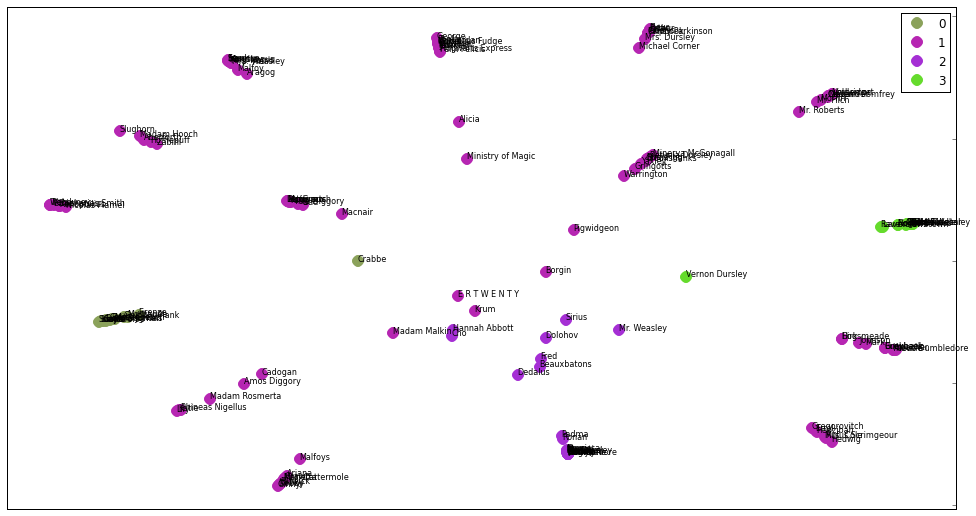

In [115]:
#The following is taken word for word from this tutorial: http://brandonrose.org/clustering

# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')

ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8)  



plt.show() #show the plot


In [116]:
#uncomment the below to save the plot if need be
plt.savefig('clusters_small_noaxes.png', dpi=200)
plt.close()

#### Create and show dendrogram for the characters (again taken from the dude's tutorial)

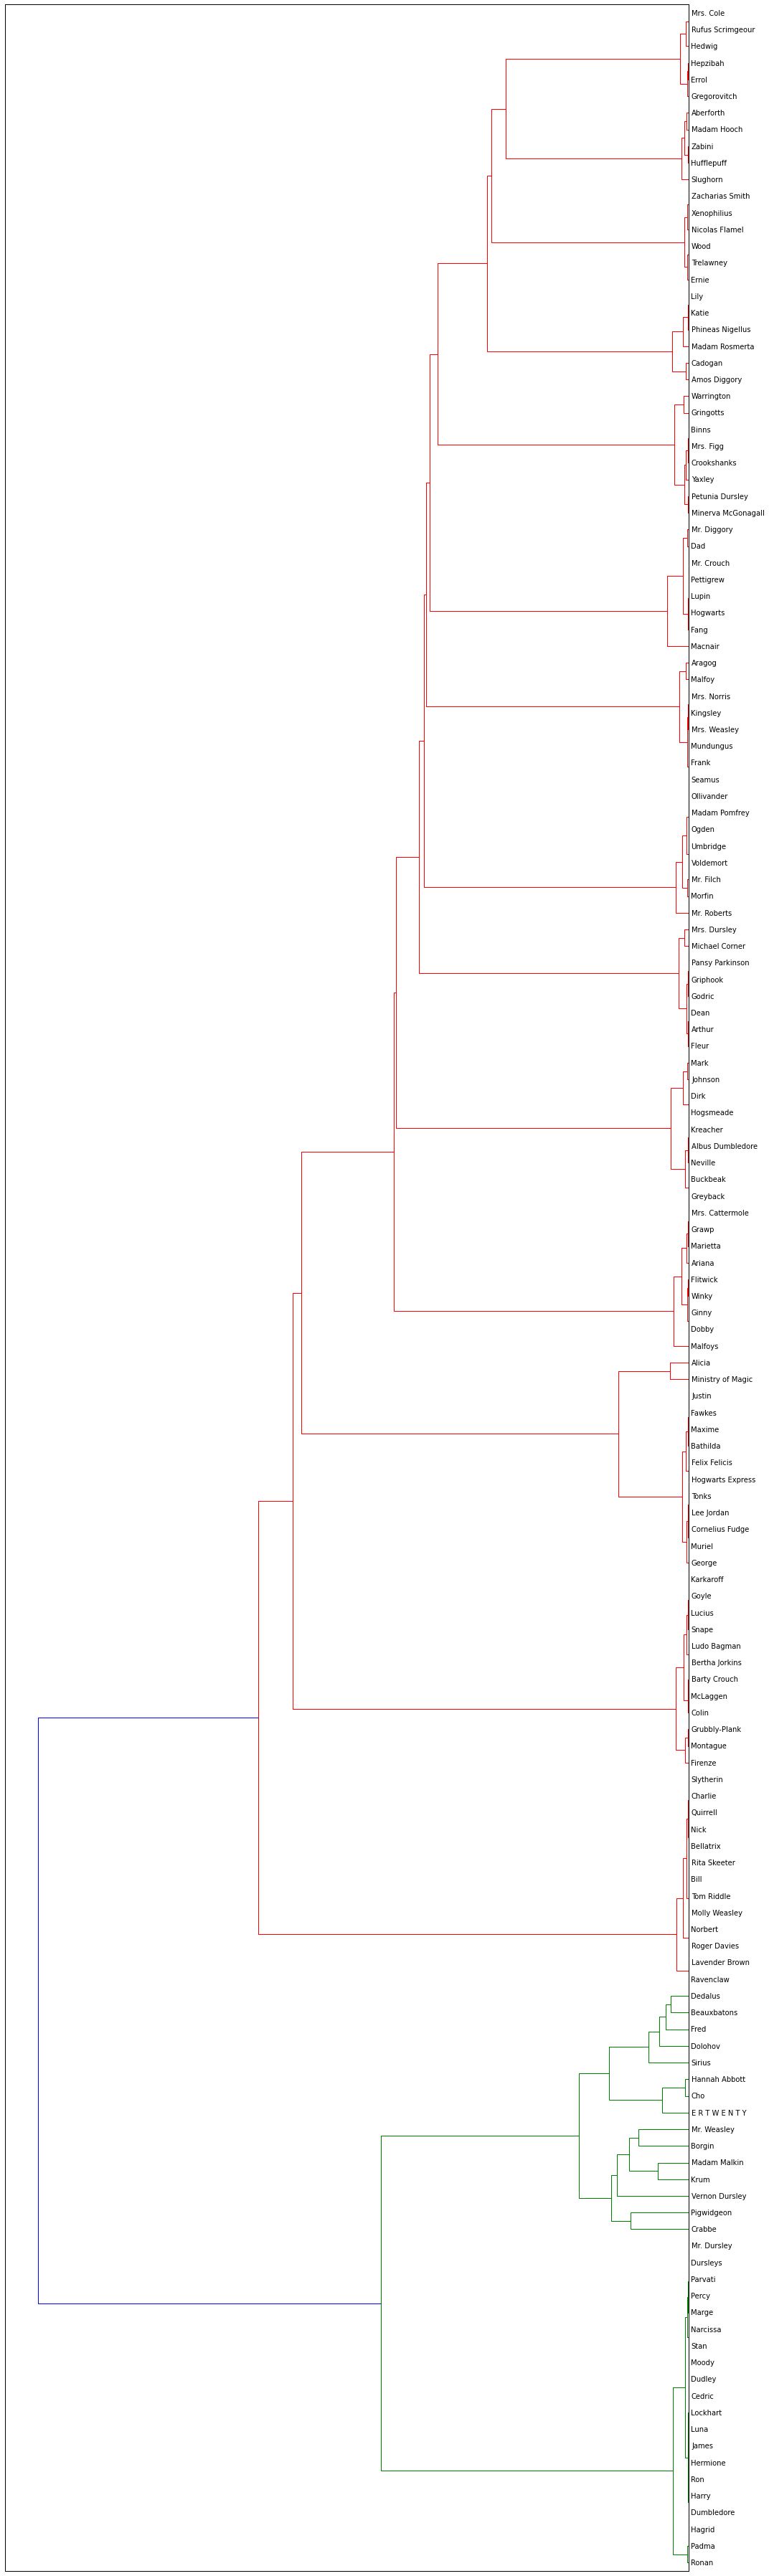

In [117]:
linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 50)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=charClusts['characters']);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters